In [2]:
import jax.numpy as jnp
import jax
# Computational grid
L          = 1                       # domain size
nodes      = jnp.array([0, L])        # nodal coordinates
nnodes     = len(nodes)              # number of nodes
nelements  = 1                       # number of elements
nparticles = 1                       # number of particles
el_length  = L / nelements           # element length

# Initial conditions 
v0         = 0.1                     # initial velocity
x_loc      = 0.5                     # location to get analytical solution

# Material property
E          = 4 * (jnp.pi)**2          # Young's modulus
rho        = 1.                      # Density

# Material points
x_p        = 0.5 * el_length         # position
mass_p     = 1.                      # mass
vol_p      = el_length / nparticles  # volume
vel_p      = v0                      # velocity
stress_p   = 0.                      # stress
strain_p   = 0.                      # strain
mv_p       = mass_p * vel_p          # momentum = m * v

# Time
duration   = 10
dt         = 0.01
time       = 0
nsteps     = int(duration/dt)

# Store time, velocity and position with time
time_t, vel_t, x_t, se_t, ke_t, te_t = [], [], [], [], [], []

@jax.jit
def update(x_p, vel_p, stress_p,strain_p,time,mv_p):
    # shape function and derivative
    N  = jnp.array([1 - abs(x_p - nodes[0])/L, 1 - abs(x_p - nodes[1])/L])
    dN = jnp.array([-1/L, 1/L])

    # map particle mass and momentum to nodes
    mass_n = N * mass_p
    mv_n   = N * mv_p
    
    # apply boundary condition: velocity at left node is zero
    mv_n=mv_n.at[0].set(0)

    # external force at nodes
    f_ext_n = jnp.array([0, 0])

    # compute internal force at nodes
    f_int_n = - dN * vol_p * stress_p 

    # total forces at nodes
    f_total_n = f_int_n + f_ext_n

    # apply boundary condition: left node has no acceleration (f = m * a, and a = 0)
    f_total_n=f_total_n.at[0].set(0)

    # update nodal momentum
    mv_n += f_total_n * dt

    # update particle position and velocity
    vel_p+=jnp.sum((dt*N*f_total_n)/mass_n)
    x_p += jnp.sum((dt * N * mv_n) / mass_n)
    # update particle momentum
    mv_p = mass_p * vel_p

    # map nodal velocity
    vel_n = mass_p * vel_p * jnp.divide(N, mass_n)
    # Apply boundary condition and set left nodal velocity to zero
    vel_n=vel_n.at[0].set(0)

    # compute strain rate at the particle
    strain_rate_p = jnp.dot(dN, vel_n) 
    # compute strain increament 
    dstrain_p = strain_rate_p * dt
    # compute strain
    strain_p += dstrain_p
    # compute stress
    stress_p += E * dstrain_p
    time += dt
    return x_p,vel_p,stress_p,strain_p,time,mv_p
for _ in range(nsteps):
    x_p,vel_p,stress_p,strain_p,time,mv_p=update(x_p,vel_p,stress_p,strain_p,time,mv_p)
    time_t.append(time)
    vel_t.append(vel_p)
    x_t.append(x_p)
    strain_energy = 0.5 * stress_p * strain_p * vol_p
    kinetic_energy = 0.5 * vel_p**2 * mass_p**2
    total_energy = strain_energy + kinetic_energy
    se_t.append(strain_energy)
    ke_t.append(kinetic_energy)
    te_t.append(total_energy)

In [3]:
import numpy as np
import jax.numpy as jnp
from jax import jit
# Analytical solution
def analytical_vibration(E, rho, v0, x_loc, duration, dt, L):
    nsteps = int(duration/dt)
    tt, vt, xt = [], [], []
    t = 0
    for _ in range(nsteps):
        omega = 1. / L * jnp.sqrt(E / rho)
        v = v0 * jnp.cos(omega * t)
        x = x_loc * jnp.exp(v0 / (L * omega) * jnp.sin(omega * t))
        vt.append(v)
        xt.append(x)
        tt.append(t)
        t += dt
    return jnp.array(tt), jnp.array(vt), jnp.array(xt)

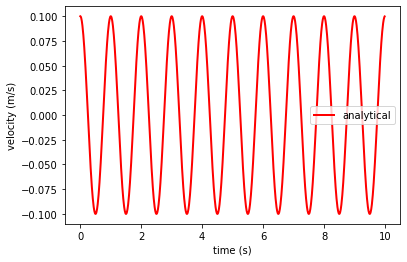

In [4]:
import matplotlib.pyplot as plt

# Young's modulus
E = 4 * (jnp.pi)**2

# analytical solution at the end of the bar
ta, va, xa = analytical_vibration(E = E, rho = 1, v0 = 0.1, x_loc = 1.0, duration = 10, dt = 0.01, L = 1.0)

plt.plot(ta, va, 'r',linewidth=2,label='analytical')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

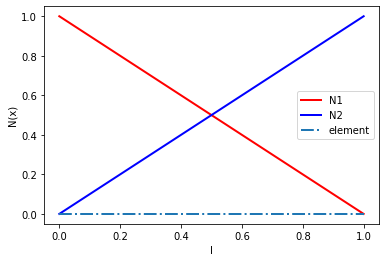

In [5]:
import matplotlib.pyplot as plt

nodes = np.array([0, L])
xs = np.arange(0, L+0.1, 0.1)
y = np.zeros_like(xs)

# shape function
n1 = [1 - abs(x - nodes[0])/L for x in xs]
n2 = [1 - abs(x - nodes[1])/L for x in xs]

plt.plot(xs, n1, 'r', linewidth=2, label='N1')
plt.plot(xs, n2, 'b', linewidth=2, label='N2')
plt.plot(xs, y, '-.', linewidth=2, label='element')
plt.xlabel('l')
plt.ylabel('N(x)')
plt.legend()
plt.show()

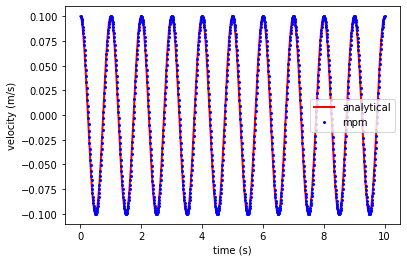

In [6]:
ta, va, xa = analytical_vibration(E, rho, v0, x_loc, duration, dt, L)

plt.plot(ta, va, 'r', linewidth=2,label='analytical')
plt.plot(time_t, vel_t, 'ob', markersize = 2, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()


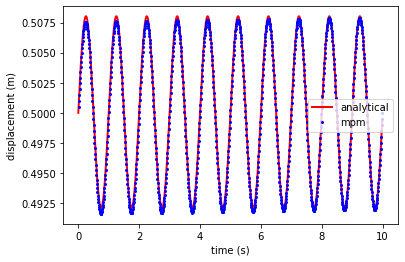

In [7]:
plt.plot(ta, xa, 'r',linewidth=2,label='analytical')
plt.plot(time_t, x_t, 'ob', markersize = 2, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.legend()
plt.show()

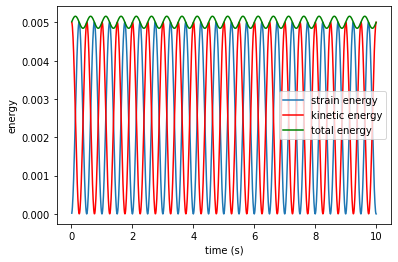

In [8]:
plt.plot(time_t, se_t, '-', markersize = 2, label='strain energy')
plt.plot(time_t, ke_t, 'r', markersize = 2, label='kinetic energy')
plt.plot(time_t, te_t, 'g', markersize = 2, label='total energy')

plt.xlabel('time (s)')
plt.ylabel('energy')
plt.legend()
plt.show()

In [ ]:
#By Krishna Kumar, Shyamini Kularathna
#© Copyright 2022.